In [1]:
# Maurice LeBlanc Crime Novel Analysis
# Step-by-step code for data exploration, feature extraction, and modeling

# Import necessary libraries
import os
import requests
import re
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('all')

[nltk_data] Downloading package punkt to C:\Users\Shivaji
[nltk_data]     Moparthy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Shivaji
[nltk_data]     Moparthy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\Shivaji
[nltk_data]    |     Moparthy\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to C:\Users\Shivaji
[nltk_data]    |     Moparthy\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Shivaji
[nltk_data]    |     Moparthy\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package

True

In [9]:
# Function to dynamically load a book from Project Gutenberg
def load_book_from_gutenberg(book_id):
    """
    This function takes a Project Gutenberg book ID and fetches the plain text version of the book.
    Example ID: Arsène Lupin, Gentleman-Burglar (ID 6133)
    """
    url = f'https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt'  # Using '-0.txt' to get UTF-8 plain text
    response = requests.get(url)
    
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to load the book with ID: {book_id}")
        return None

In [10]:
# Load a Maurice Leblanc novel dynamically (Arsène Lupin, Gentleman-Burglar - ID 6133)
novel_text = load_book_from_gutenberg(6133)  # Example: Arsène Lupin, Gentleman-Burglar

# Check if the novel was loaded successfully
if novel_text:
    print("Book loaded successfully!")
else:
    raise Exception("Failed to load the book.")

Book loaded successfully!


In [11]:
# Text Preprocessing: Tokenization and Normalization
def preprocess_text(text):
    # Lowercasing, removing special characters, and tokenizing
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokenizer = TreebankWordTokenizer()  # Use Treebank tokenizer instead of word_tokenize
    tokens = tokenizer.tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Process the text after modifying the tokenizer
tokens = preprocess_text(novel_text)
print(tokens[:50])  # Display the first 50 tokens as an example

['project', 'gutenberg', 'ebook', 'extraordinary', 'adventures', 'arsne', 'lupin', 'gentlemanburglar', 'maurice', 'leblanc', 'ebook', 'use', 'anyone', 'anywhere', 'united', 'states', 'parts', 'world', 'cost', 'almost', 'restrictions', 'whatsoever', 'may', 'copy', 'give', 'away', 'reuse', 'terms', 'project', 'gutenberg', 'license', 'included', 'ebook', 'online', 'wwwgutenbergorg', 'located', 'united', 'states', 'check', 'laws', 'country', 'located', 'using', 'ebook', 'title', 'extraordinary', 'adventures', 'arsne', 'lupin', 'gentlemanburglar']


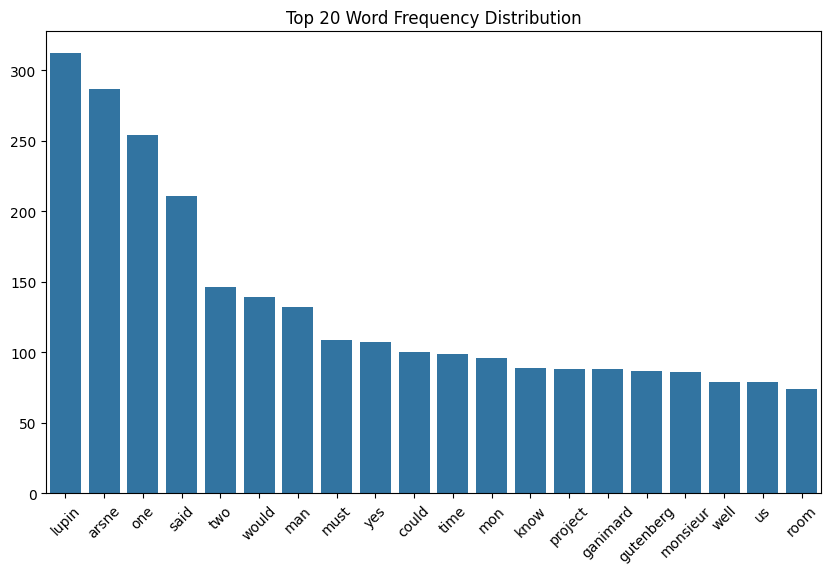

In [12]:

# Exploratory Data Analysis: Word Frequency Distribution
def plot_word_distribution(tokens, top_n=20):
    freq_dist = FreqDist(tokens)
    common_words = freq_dist.most_common(top_n)
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts))
    plt.title(f'Top {top_n} Word Frequency Distribution')
    plt.xticks(rotation=45)
    plt.show()

plot_word_distribution(tokens)

In [13]:
# Feature Engineering: Character and Event-Based Features

# For simplicity, we define placeholder functions for feature extraction (you can improve them based on your dataset)

# Example 1: Character-based features (First appearance of Arsène Lupin)
def find_first_appearance(character, text):
    sentences = sent_tokenize(text)
    for i, sentence in enumerate(sentences):
        if character.lower() in sentence.lower():
            return i
    return -1

first_lupin_appearance = find_first_appearance("Arsène Lupin", novel_text)
print(f'Arsène Lupin first appears at sentence index: {first_lupin_appearance}')

Arsène Lupin first appears at sentence index: 0


In [14]:
# Example 2: Event-based features (Crime scene keyword frequency)
def count_crime_keywords(text, keywords):
    tokens = preprocess_text(text)
    keyword_counts = {keyword: tokens.count(keyword) for keyword in keywords}
    return keyword_counts

crime_keywords = ['crime', 'murder', 'theft', 'robbery']
crime_keyword_counts = count_crime_keywords(novel_text, crime_keywords)
print('Crime keyword counts:', crime_keyword_counts)

Crime keyword counts: {'crime': 18, 'murder': 5, 'theft': 17, 'robbery': 8}


In [15]:
# Model: Supervised Learning for Perpetrator Prediction

# For demonstration purposes, create dummy feature data
# In real application, extract real features from text data
data = {
    'first_appearance': [5, 10, 15, 20, 25],  # Example of character's first appearance (index)
    'interactions': [10, 20, 15, 30, 5],      # Example interaction counts
    'sentiment': [0.5, 0.7, 0.3, 0.6, 0.2]    # Example sentiment scores
}

# Labels: Assume we have a binary label for whether a character is the perpetrator
labels = [1, 0, 1, 0, 1]  # Example: 1 = Perpetrator, 0 = Not

# Convert data to DataFrame
df = pd.DataFrame(data)
X = df
y = labels

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [16]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Cross-validation (to assess model generalization)
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {np.mean(cv_scores)}')

Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



C:\Users\Shivaji Moparthy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shivaji Moparthy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shivaji Moparthy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

ValueError: n_splits=5 cannot be greater than the number of members in each class.

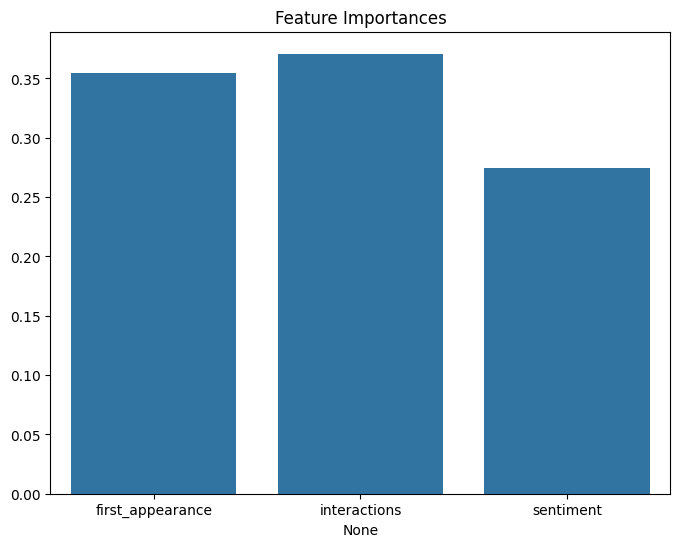

Logistic Regression Accuracy: 0.5


In [17]:
# Visualize Feature Importances (from Random Forest)
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(8, 6))
sns.barplot(x=df.columns, y=feature_importances)
plt.title('Feature Importances')
plt.show()

# You can similarly implement Logistic Regression, or other models
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print(f'Logistic Regression Accuracy: {accuracy_score(y_test, log_pred)}')